# Initial Setup

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

## Folder Setup

In [2]:
from pathlib import Path

# notebook mappa → menjünk fel a repo gyökeréhez
repo_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

DATA_REPO = repo_root / "data_repository"
FIG_REPO  = repo_root / "figure_repository"
CLUSTER_DATA     = DATA_REPO / "cluster_data"
TIME_SERIES_DATA = DATA_REPO / "time_series"
METRICS_DATA     = DATA_REPO / "metrics"
RUNTIME_DATA     = DATA_REPO / "runtime"

## Figure Setups

In [3]:
CONTEXT = "petroff10"
FIGSIZE = (6, 3)
LABELSIZE = 14
TICKSIZE  = 12 

## Helper Functions

In [69]:
def get_cluster_config(num_bubbles, seed):
    return f"N-{num_bubbles:0.0f}-DVar-1000.00-dMin-150.00-dType-randomized-RE--0.8--5.0--RType-randomized-S-{seed:.0f}"

def get_run_name(P1, P2):
    return f"P1-{P1:0.2f}-P2-{P2:0.2f}-P3-0.00-P4-0.00"

def load_bruteforce_metrics(num_bubbles, seeds, PAs, P2):
    rmax = []
    omega_opt = []
    cluster = [] 
    amps = []
    for seed in seeds:
        for pA in PAs:
            metrics_path = METRICS_DATA / get_cluster_config(num_bubbles, seed) / get_run_name(pA, P2)
            metrics = np.load(f"{metrics_path}_jacobi_bruteforce.npz")
            rmax.append(metrics["rmax"])
            omega_opt.append(metrics["omega"])
            cluster.extend([seed] * len(metrics["time"]))
            amps.extend([pA] * len(metrics["time"]))

    rmax = np.hstack(rmax)
    omega_opt = np.hstack(omega_opt)

    df = pd.DataFrame(
        {
            "seed"  : cluster,
            "P1"    : amps,
            "rmax"  : rmax,
            "omega" : omega_opt
        }
    )

    return df

def load_runtimes_iterations(num_bubbles, seed, PAs, P2):
    baseline = []
    runtime_jacobi  = []
    runtime_fitted  = []
    runtime_bicg    = []
    iter_jacobi     = []
    iter_fitted     = []
    iter_bruteforce = []
    iter_bicg       = []
    iter_pa         = []
    runtime_pa      = []
    for pA in PAs:
        metrics_data = METRICS_DATA / get_cluster_config(num_bubbles, seed) / get_run_name(pA, P2)
        iter_bruteforce.append(np.sum(np.load(f"{metrics_data}_jacobi_bruteforce.npz")["iters"]))
        iter_fitted.append(np.sum(np.load(f"{metrics_data}_jacobi_fitted.npz")["iters"]))
        iter_bicg.append(np.sum(np.load(f"{metrics_data}_bicg.npz")["iters"]))
        iter_pa.append(pA)

        runtime_data = RUNTIME_DATA / get_cluster_config(num_bubbles, seed)  / get_run_name(pA, P2)
        baseline.append((np.load(f"{runtime_data}_baseline.npz")["sim_time"]))
        runtime_fitted.append(np.load(f"{runtime_data}_jacobi_fitted.npz")["sim_time"])
        runtime_bicg.append(np.load(f"{runtime_data}_bicg.npz")["sim_time"])

        try:
            runtime_jacobi.append(np.load(f"{runtime_data}_jacobi_baseline.npz")["sim_time"])
            iter_jacobi.append(np.sum(np.load(f"{metrics_data}_jacobi_baseline.npz")["iters"]))
        except:
            runtime_jacobi.append([np.inf] * len(runtime_bicg[-1] ))
            iter_jacobi.append(np.inf)
                                  
        runtime_pa.extend([pA] * len(runtime_bicg[-1]))   


    iter_df = pd.DataFrame(
        {
            "P1" : iter_pa,
            "Jacobi" : iter_jacobi,
            "Jacobi-BruteForece" : iter_bruteforce,
            "Jacobi-Fitted" : iter_fitted,
            "BiCG" : iter_bicg
        }
    )

    runtime_df = pd.DataFrame(
        {
            "P1" : runtime_pa,
            "Jacobi" : np.hstack(runtime_jacobi),
            "Jacobi Fitted" : np.hstack(runtime_fitted),
            "BiCG"  : np.hstack(runtime_bicg),
            "Direct" : np.hstack(baseline)
        }
    )

    return iter_df, runtime_df


# Cluster / Bubble Arrangement

In [44]:
TIMESTEP = 6700
NUM_BUBBLES = 32
SEED = 21
CLUSTER_CONFIG = get_cluster_config(NUM_BUBBLES, SEED)
cluster_data = np.load(CLUSTER_DATA / f"{get_cluster_config(NUM_BUBBLES, SEED)}.npz")
bubble_positions = cluster_data["bubble_positions"]
bubble_sizes     = cluster_data["bubble_sizes"]

P1 = 2.4
P2 = 25.0
RUN_CONFIG = get_run_name(P1, P2)
time_series = np.load(TIME_SERIES_DATA / CLUSTER_CONFIG / f"{RUN_CONFIG}_jacobi_bruteforce.npz")
metrics_bf  = np.load(METRICS_DATA / CLUSTER_CONFIG / f"{RUN_CONFIG}_jacobi_bruteforce.npz")
metrics_fit  = np.load(METRICS_DATA / CLUSTER_CONFIG / f"{RUN_CONFIG}_jacobi_fitted.npz")
metrics_bicg = np.load(METRICS_DATA / CLUSTER_CONFIG / f"{RUN_CONFIG}_bicg.npz")

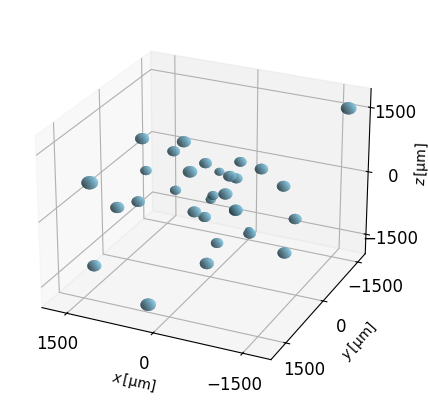

In [45]:
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")

    # minden buborék kirajzolása gömbként
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    for (x, y, z), r in zip(bubble_positions, time_series["radii_micron"][TIMESTEP]):
        xs = r * np.outer(np.cos(u), np.sin(v)) + x
        ys = r * np.outer(np.sin(u), np.sin(v)) + y
        zs = r * np.outer(np.ones_like(u), np.cos(v)) + z
        ax.plot_surface(xs, ys, zs, color="skyblue", alpha=1.0, linewidth=0)

    # méretarány megtartása (az alap matplotlib nem skáláz egyformán minden tengelyt)
    max_range = (bubble_positions.max(axis=0) - bubble_positions.min(axis=0)).max()
    mid = bubble_positions.mean(axis=0)
    ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
    ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
    ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)

    ax.view_init(elev=25, azim=115)

    ax.set_xticks([-1500, 0, 1500])
    ax.set_yticks([-1500, 0, 1500])
    ax.set_zticks([-1500, 0, 1500])
    ax.set_xlabel(r"$x\, [\mathrm{\mu m}]$")
    ax.set_ylabel(r"$y\, [\mathrm{\mu m}]$")
    ax.set_zlabel(r"$z\, [\mathrm{\mu m}]$")

    # Tickek méretének állítása
    plt.tick_params(axis='both', which='major', labelsize=TICKSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=TICKSIZE)  # kisebb tickek, ha vannak

#plt.tight_layout(h_pad=0.5)
plt.show()

fig.savefig(FIG_REPO / "cluster.pdf", dpi=100)

# Radius Time Curve / BruteForce Search

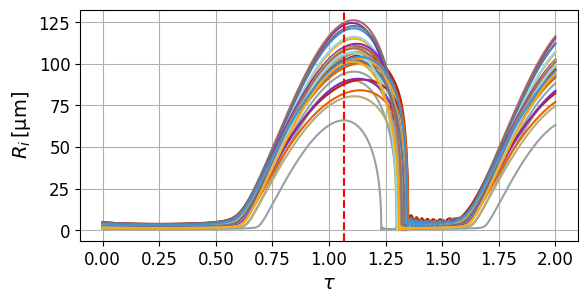

In [46]:
# Radius Time Curve
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.95, right=0.98)
    plt.plot(time_series["time"], time_series["radii_micron"], linewidth=1.5)
    plt.xlabel(r"$\tau$", fontsize=LABELSIZE)
    plt.ylabel(r"$R_i\, [\mathrm{\mu m}]$", fontsize=LABELSIZE)
    plt.axvline(time_series["time"][TIMESTEP], color="r", linestyle="--")

    # Tickek méretének állítása
    plt.tick_params(axis='both', which='major', labelsize=TICKSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=TICKSIZE)  # kisebb tickek, ha vannak
    plt.grid("both")

#plt.tight_layout()
plt.show()

fig.savefig(FIG_REPO / "radius_time.pdf", dpi=100)

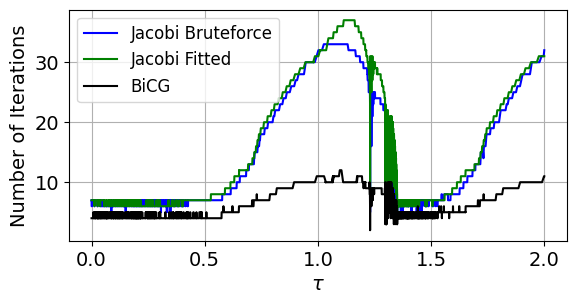

In [47]:
# Iterations
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.95, right=0.98)
    plt.plot(metrics_bf["time"], metrics_bf["iters"], linewidth=1.5, label="Jacobi Bruteforce", color="b")
    plt.plot(metrics_fit["time"], metrics_fit["iters"], linewidth=1.5, label="Jacobi Fitted", color="g")
    plt.plot(metrics_bicg["time"], metrics_bicg["iters"], linewidth=1.5, label="BiCG", color="k")
    plt.xlabel(r"$\tau$", fontsize=LABELSIZE)
    plt.ylabel(r"Number of Iterations", fontsize=LABELSIZE)
    plt.legend(fontsize=TICKSIZE)
    # Tickek méretének állítása
    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak
    plt.grid("both")

#plt.tight_layout()
plt.show()

fig.savefig(FIG_REPO / "iterations.pdf", dpi=100)

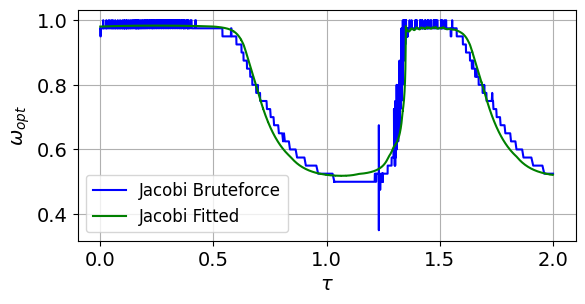

In [48]:
# Omega 
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.95, right=0.98)
    plt.plot(metrics_bf["time"], metrics_bf["omega"], linewidth=1.5, label="Jacobi Bruteforce", color="b")
    plt.plot(metrics_fit["time"], metrics_fit["omega"], linewidth=1.5, label="Jacobi Fitted", color="g")
    plt.xlabel(r"$\tau$", fontsize=LABELSIZE)
    plt.ylabel(r"$\omega_{opt}$", fontsize=LABELSIZE)
    plt.legend(fontsize=TICKSIZE)
    # Tickek méretének állítása
    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak
    plt.grid("both")

#plt.tight_layout()
plt.show()

fig.savefig(FIG_REPO / "omega.pdf", dpi=100)

# Optimal Omega + Fitted Line

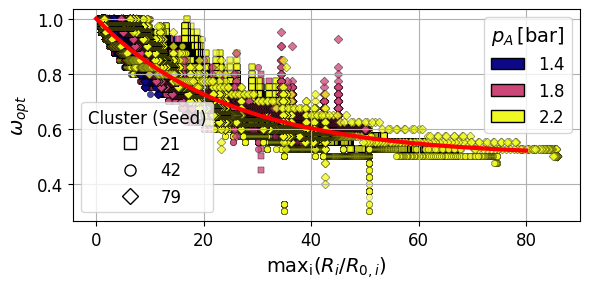

In [22]:
omegea_opt = lambda rmax : 0.5 + 0.5 * np.exp(-0.04 * rmax)
df = load_bruteforce_metrics(32, [21, 42, 79], [2.2, 1.8, 1.4], 25.0)

marker_by_seed = {
    42: "o",   # kör
    21: "s",   # négyzet
    79: "D",   # rombusz
}
# Ha netán más seed is becsúszik, kapjon alapértelmezett jelölőt:
default_marker = "o"

# P1-értékek → zöld árnyalatok (diszkrét skála a meglévő egyedi P1-ekre)
unique_p1 = np.sort(df["P1"].unique())
cmap = plt.get_cmap("plasma", len(unique_p1))  # ennyi egyedi színt kérünk
color_by_p1 = {p: cmap(i) for i, p in enumerate(unique_p1)}


with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.95, right=0.98)
    ax = fig.gca()
    # Szórásdiagram: csoportosítunk seed és P1 szerint, hogy a marker-szín párosítás megmaradjon
    for seed, g_seed in df.groupby("seed"):
        m = marker_by_seed.get(seed, default_marker)
        for p1, g in g_seed.groupby("P1"):
            ax.scatter(
                g["rmax"], g["omega"],
                marker=m,
                s=20,
                edgecolor="k",
                linewidth=0.3,
                color=color_by_p1[p1],
                alpha=0.5,
                label=None
            )

    plt.plot(np.linspace(0, 80), omegea_opt(np.linspace(0, 80)), "r-", linewidth=3)

    # Tengelycímkék
    ax.set_xlabel(r"$\mathrm{max_i}(R_i/R_{0,i})$", fontsize=LABELSIZE)
    ax.set_ylabel(r"$\omega_{opt}$", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=TICKSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=TICKSIZE)  # kisebb tickek, ha vannak

    # --- jelmagyarázatok ---
    # 1) Seed legend (markerek)
    seed_handles = [
        Line2D([0], [0], marker=marker_by_seed.get(s, default_marker),
            linestyle="None", markersize=8, markeredgecolor="k",
            markerfacecolor="white", label=f"{s}")
        for s in sorted(df["seed"].unique())
    ]

    # 2) P1 legend (zöld árnyalatok)
    p1_handles = [
        Patch(facecolor=color_by_p1[p], edgecolor="k", label=r"$%.1f$" % p)
        for p in unique_p1
    ]

    leg1 = ax.legend(handles=seed_handles, title="Cluster (Seed)", loc="lower left", title_fontsize=TICKSIZE, fontsize=TICKSIZE)
    ax.add_artist(leg1)  # hogy megmaradjon a második legenda mellett
    ax.legend(handles=p1_handles, title=r"$p_{A}\, [\mathrm{bar}]$", loc="upper right", title_fontsize=TICKSIZE+2, fontsize=TICKSIZE)

    #ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.grid("both")
    plt.show()

    fig.savefig(FIG_REPO / "omege_fit_32.png", dpi=100)
    fig.savefig(FIG_REPO / "omege_fit_32.pdf", dpi=100)

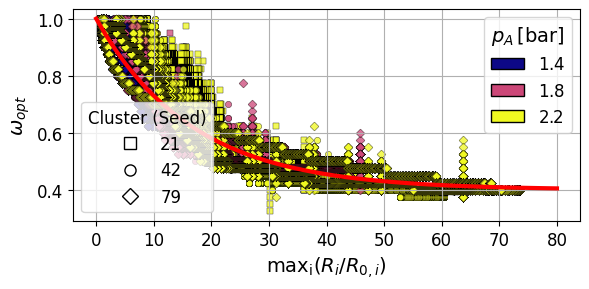

In [21]:
omegea_opt = lambda rmax : 0.4 + 0.6 * np.exp(-0.06 * rmax)
df = load_bruteforce_metrics(64, [21, 42, 79], [2.2, 1.8, 1.4], 25.0)

marker_by_seed = {
    42: "o",   # kör
    21: "s",   # négyzet
    79: "D",   # rombusz
}
# Ha netán más seed is becsúszik, kapjon alapértelmezett jelölőt:
default_marker = "o"

# P1-értékek → zöld árnyalatok (diszkrét skála a meglévő egyedi P1-ekre)
unique_p1 = np.sort(df["P1"].unique())
cmap = plt.get_cmap("plasma", len(unique_p1))  # ennyi egyedi színt kérünk
color_by_p1 = {p: cmap(i) for i, p in enumerate(unique_p1)}


with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.95, right=0.98)
    ax = fig.gca()
    # Szórásdiagram: csoportosítunk seed és P1 szerint, hogy a marker-szín párosítás megmaradjon
    for seed, g_seed in df.groupby("seed"):
        m = marker_by_seed.get(seed, default_marker)
        for p1, g in g_seed.groupby("P1"):
            ax.scatter(
                g["rmax"], g["omega"],
                marker=m,
                s=20,
                edgecolor="k",
                linewidth=0.3,
                color=color_by_p1[p1],
                alpha=0.5,
                label=None
            )

    plt.plot(np.linspace(0, 80), omegea_opt(np.linspace(0, 80)), "r-", linewidth=3)

    # Tengelycímkék
    ax.set_xlabel(r"$\mathrm{max_i}(R_i/R_{0,i})$", fontsize=LABELSIZE)
    ax.set_ylabel(r"$\omega_{opt}$", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=TICKSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=TICKSIZE)  # kisebb tickek, ha vannak

    # --- jelmagyarázatok ---
    # 1) Seed legend (markerek)
    seed_handles = [
        Line2D([0], [0], marker=marker_by_seed.get(s, default_marker),
            linestyle="None", markersize=8, markeredgecolor="k",
            markerfacecolor="white", label=f"{s}")
        for s in sorted(df["seed"].unique())
    ]

    # 2) P1 legend (zöld árnyalatok)
    p1_handles = [
        Patch(facecolor=color_by_p1[p], edgecolor="k", label=r"$%.1f$" % p)
        for p in unique_p1
    ]

    leg1 = ax.legend(handles=seed_handles, title="Cluster (Seed)", loc="lower left", title_fontsize=TICKSIZE, fontsize=TICKSIZE)
    ax.add_artist(leg1)  # hogy megmaradjon a második legenda mellett
    ax.legend(handles=p1_handles, title=r"$p_{A}\, [\mathrm{bar}]$", loc="upper right", title_fontsize=TICKSIZE+2, fontsize=TICKSIZE)

    #ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.grid("both")
    plt.show()

    fig.savefig(FIG_REPO / "omege_fit_64.png", dpi=100)
    fig.savefig(FIG_REPO / "omege_fit_64.pdf", dpi=100)

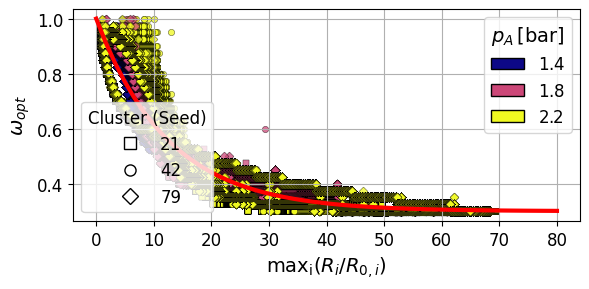

In [38]:
omegea_opt = lambda rmax : 0.30 + 0.70 * np.exp(-0.08 * rmax)
df = load_bruteforce_metrics(128, [21, 42, 79], [2.2, 1.8, 1.4], 25.0)

marker_by_seed = {
    42: "o",   # kör
    21: "s",   # négyzet
    79: "D",   # rombusz
}
# Ha netán más seed is becsúszik, kapjon alapértelmezett jelölőt:
default_marker = "o"

# P1-értékek → zöld árnyalatok (diszkrét skála a meglévő egyedi P1-ekre)
unique_p1 = np.sort(df["P1"].unique())
cmap = plt.get_cmap("plasma", len(unique_p1))  # ennyi egyedi színt kérünk
color_by_p1 = {p: cmap(i) for i, p in enumerate(unique_p1)}


with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.15, bottom=0.18, top=0.95, right=0.98)
    ax = fig.gca()
    # Szórásdiagram: csoportosítunk seed és P1 szerint, hogy a marker-szín párosítás megmaradjon
    for seed, g_seed in df.groupby("seed"):
        m = marker_by_seed.get(seed, default_marker)
        for p1, g in g_seed.groupby("P1"):
            ax.scatter(
                g["rmax"], g["omega"],
                marker=m,
                s=20,
                edgecolor="k",
                linewidth=0.3,
                color=color_by_p1[p1],
                alpha=0.5,
                label=None
            )

    plt.plot(np.linspace(0, 80), omegea_opt(np.linspace(0, 80)), "r-", linewidth=3)

    # Tengelycímkék
    ax.set_xlabel(r"$\mathrm{max_i}(R_i/R_{0,i})$", fontsize=LABELSIZE)
    ax.set_ylabel(r"$\omega_{opt}$", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=TICKSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=TICKSIZE)  # kisebb tickek, ha vannak

    # --- jelmagyarázatok ---
    # 1) Seed legend (markerek)
    seed_handles = [
        Line2D([0], [0], marker=marker_by_seed.get(s, default_marker),
            linestyle="None", markersize=8, markeredgecolor="k",
            markerfacecolor="white", label=f"{s}")
        for s in sorted(df["seed"].unique())
    ]

    # 2) P1 legend (zöld árnyalatok)
    p1_handles = [
        Patch(facecolor=color_by_p1[p], edgecolor="k", label=r"$%.1f$" % p)
        for p in unique_p1
    ]

    leg1 = ax.legend(handles=seed_handles, title="Cluster (Seed)", loc="lower left", title_fontsize=TICKSIZE, fontsize=TICKSIZE)
    ax.add_artist(leg1)  # hogy megmaradjon a második legenda mellett
    ax.legend(handles=p1_handles, title=r"$p_{A}\, [\mathrm{bar}]$", loc="upper right", title_fontsize=TICKSIZE+2, fontsize=TICKSIZE)

    #ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.grid("both")
    plt.show()

    #fig.savefig(FIG_REPO / "omege_fit_128.png", dpi=100)
    #fig.savefig(FIG_REPO / "omege_fit_128.pdf", dpi=100)

# Runtime vs Iteratios

In [70]:
iter_df, runtime_df = load_runtimes_iterations(64, 21, np.arange(0.6, 2.2, 0.2), 25)
runtime_df.head()

,P1,Jacobi,Jacobi Fitted,BiCG,Direct
0,0.6,3.526710,3.635892,3.286630,4.751141
1,0.6,3.546097,3.569082,3.268691,4.757255
2,0.6,3.539090,3.563147,3.287222,4.747584
3,0.6,3.516486,3.550069,3.317411,5.022467
4,0.6,3.511954,3.572084,3.297983,4.771027


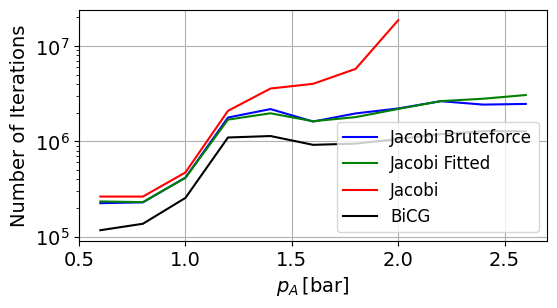

In [86]:
iter_df, runtime_df = load_runtimes_iterations(32, 21, np.arange(0.6, 2.8, 0.2), 25)
# NUmber of Iterations
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.20, bottom=0.18, top=0.95, right=0.98)
    plt.plot(iter_df["P1"], iter_df["Jacobi-BruteForece"], label="Jacobi Bruteforce", linewidth=1.5, color="b")
    plt.plot(iter_df["P1"], iter_df["Jacobi-Fitted"], label="Jacobi Fitted", linewidth=1.5, color="g")
    plt.plot(iter_df["P1"], iter_df["Jacobi"], label="Jacobi", linewidth=1.5, color="r")
    plt.plot(iter_df["P1"], iter_df["BiCG"], label="BiCG", linewidth=1.5, color="k")

    plt.xlabel(r"$p_{A}\, [\mathrm{bar}]$", fontsize=LABELSIZE)
    plt.ylabel(r"Number of Iterations", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak

    plt.legend(fontsize=TICKSIZE)
    plt.yscale("log")
    plt.grid("both")

plt.show()
fig.savefig(FIG_REPO / "num_iters_32.pdf", dpi=100)

In [87]:
long = runtime_df.melt(id_vars="P1",
               value_vars=["Jacobi", "Jacobi Fitted", "BiCG", "Direct"],
               var_name="solver", value_name="time")

stats = (long
         .groupby(["P1","solver"])
         .agg(mean=("time","mean"),
              std=("time","std"),
              n=("time","size"))
         .reset_index())

#stats

In [88]:
from scipy.stats import t
stats["tcrit"] = t.ppf(0.975, df=stats["n"] - 1)
stats["ci95"] = stats["tcrit"] * stats["std"] / np.sqrt(stats["n"])   # Confidence Interval

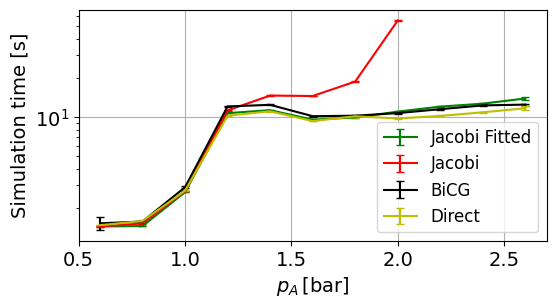

In [89]:
# Simulation time
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.20, bottom=0.18, top=0.95, right=0.98)
    for s, c in zip(["Jacobi Fitted", "Jacobi", "BiCG", "Direct"], ["g", "r", "k", "y"]):
        sub = stats[stats["solver"] == s].sort_values("P1")
        plt.errorbar(sub["P1"], sub["mean"], yerr=sub["ci95"], marker="", capsize=3, label=s, color=c, linewidth=1.5)

    plt.xlabel(r"$p_{A}\, [\mathrm{bar}]$", fontsize=LABELSIZE)
    plt.ylabel(r"Simulation time [s]", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak

    plt.legend(fontsize=TICKSIZE)
    plt.yscale("log")
    plt.grid("both")

plt.show()

fig.savefig(FIG_REPO / "simu_time_32.pdf", dpi=100)

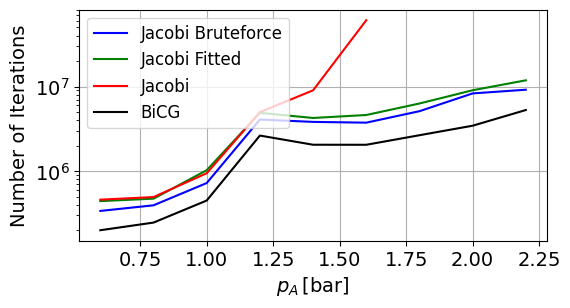

In [76]:
iter_df, runtime_df = load_runtimes_iterations(64, 21, np.arange(0.6, 2.4, 0.2), 25)
# NUmber of Iterations
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.20, bottom=0.18, top=0.95, right=0.98)
    plt.plot(iter_df["P1"], iter_df["Jacobi-BruteForece"], label="Jacobi Bruteforce", linewidth=1.5, color="b")
    plt.plot(iter_df["P1"], iter_df["Jacobi-Fitted"], label="Jacobi Fitted", linewidth=1.5, color="g")
    plt.plot(iter_df["P1"], iter_df["Jacobi"], label="Jacobi", linewidth=1.5, color="r")
    plt.plot(iter_df["P1"], iter_df["BiCG"], label="BiCG", linewidth=1.5, color="k")

    plt.xlabel(r"$p_{A}\, [\mathrm{bar}]$", fontsize=LABELSIZE)
    plt.ylabel(r"Number of Iterations", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak

    plt.legend(fontsize=TICKSIZE)
    plt.yscale("log")
    plt.grid("both")

plt.show()
fig.savefig(FIG_REPO / "num_iters_64.pdf", dpi=100)

In [77]:
long = runtime_df.melt(id_vars="P1",
               value_vars=["Jacobi", "Jacobi Fitted", "BiCG", "Direct"],
               var_name="solver", value_name="time")

stats = (long
         .groupby(["P1","solver"])
         .agg(mean=("time","mean"),
              std=("time","std"),
              n=("time","size"))
         .reset_index())

#stats

stats["tcrit"] = t.ppf(0.975, df=stats["n"] - 1)
stats["ci95"] = stats["tcrit"] * stats["std"] / np.sqrt(stats["n"])   # Confidence Interval

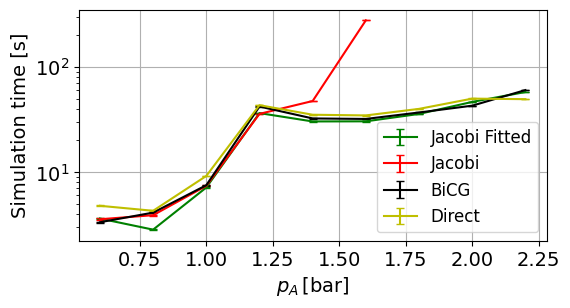

In [78]:
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.20, bottom=0.18, top=0.95, right=0.98)
    for s, c in zip(["Jacobi Fitted", "Jacobi", "BiCG", "Direct"], ["g", "r", "k", "y"]):
        sub = stats[stats["solver"] == s].sort_values("P1")
        plt.errorbar(sub["P1"], sub["mean"], yerr=sub["ci95"], marker="", capsize=3, label=s, color=c, linewidth=1.5)

    plt.xlabel(r"$p_{A}\, [\mathrm{bar}]$", fontsize=LABELSIZE)
    plt.ylabel(r"Simulation time [s]", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak

    plt.legend(fontsize=TICKSIZE)
    plt.yscale("log")
    plt.grid("both")

plt.show()

fig.savefig(FIG_REPO / "simu_time_64.pdf", dpi=100)

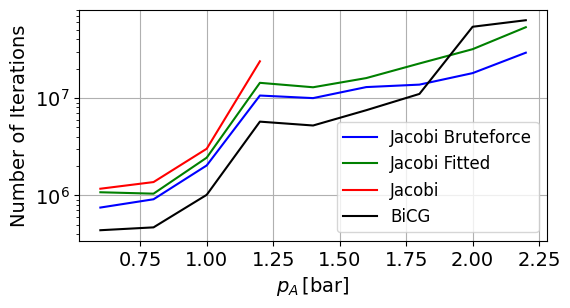

In [79]:
iter_df, runtime_df = load_runtimes_iterations(128, 21, np.arange(0.6, 2.4, 0.2), 25)
# NUmber of Iterations
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.20, bottom=0.18, top=0.95, right=0.98)
    plt.plot(iter_df["P1"], iter_df["Jacobi-BruteForece"], label="Jacobi Bruteforce", linewidth=1.5, color="b")
    plt.plot(iter_df["P1"], iter_df["Jacobi-Fitted"], label="Jacobi Fitted", linewidth=1.5, color="g")
    plt.plot(iter_df["P1"], iter_df["Jacobi"], label="Jacobi", linewidth=1.5, color="r")
    plt.plot(iter_df["P1"], iter_df["BiCG"], label="BiCG", linewidth=1.5, color="k")

    plt.xlabel(r"$p_{A}\, [\mathrm{bar}]$", fontsize=LABELSIZE)
    plt.ylabel(r"Number of Iterations", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak

    plt.legend(fontsize=TICKSIZE)
    plt.yscale("log")
    plt.grid("both")

plt.show()
fig.savefig(FIG_REPO / "num_iters_128.pdf", dpi=100)

In [80]:
long = runtime_df.melt(id_vars="P1",
               value_vars=["Jacobi", "Jacobi Fitted", "BiCG", "Direct"],
               var_name="solver", value_name="time")

stats = (long
         .groupby(["P1","solver"])
         .agg(mean=("time","mean"),
              std=("time","std"),
              n=("time","size"))
         .reset_index())

#stats

stats["tcrit"] = t.ppf(0.975, df=stats["n"] - 1)
stats["ci95"] = stats["tcrit"] * stats["std"] / np.sqrt(stats["n"])   # Confidence Interval

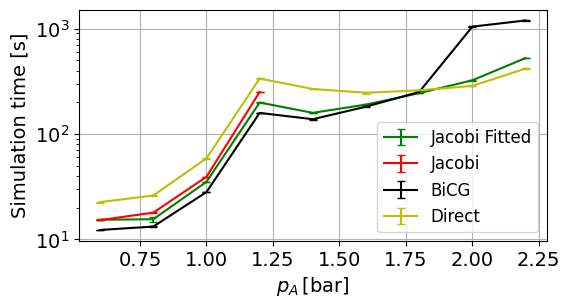

In [83]:
with plt.style.context(CONTEXT):
    fig = plt.figure(figsize=FIGSIZE)
    fig.subplots_adjust(left=0.20, bottom=0.18, top=0.95, right=0.98)
    for s, c in zip(["Jacobi Fitted", "Jacobi", "BiCG", "Direct"], ["g", "r", "k", "y"]):
        sub = stats[stats["solver"] == s].sort_values("P1")
        plt.errorbar(sub["P1"], sub["mean"], yerr=sub["ci95"], marker="", capsize=3, label=s, color=c, linewidth=1.5)

    plt.xlabel(r"$p_{A}\, [\mathrm{bar}]$", fontsize=LABELSIZE)
    plt.ylabel(r"Simulation time [s]", fontsize=LABELSIZE)

    plt.tick_params(axis='both', which='major', labelsize=LABELSIZE)  # nagy tickek
    plt.tick_params(axis='both', which='minor', labelsize=LABELSIZE)  # kisebb tickek, ha vannak

    plt.legend(fontsize=TICKSIZE)
    plt.yscale("log")
    plt.grid("both")

plt.show()

fig.savefig(FIG_REPO / "simu_time_128.pdf", dpi=100)